In [6]:
import rustworkx as rx
import stanza
import stopwords
from tqdm import tqdm

In [2]:
# Uncomment the line below if you have not downloaded this yet
# stanza.download('en')

In [7]:
# Toy dictionary, inspired by examples in Kostiuk (2023). Keys are words, values are lists of definitions
dictionary: dict[str, list[str]] = {
    "bank" : ["financial institution that accepts deposits and channels the money into lending activities", "sloping land (especially the slope beside a body of water)"],
    "bee" : ["an insect that produces honey"],
    "honey" : ["a substance produced by bees"]
}

# Lemmatize dictionary and remove stopwords
nlp = stanza.Pipeline(lang='en', processors="tokenize,mwt,pos,lemma", logging_level='WARN')
sw = stopwords.get_stopwords('en')

for word in tqdm(dictionary):
    definitions = dictionary[word]
    for i in range(len(definitions)):
        defn_info = nlp(definitions[i])
        definitions[i] = [word.lemma for sent in defn_info.sentences for word in sent.words if word.lemma not in sw]

dictionary

100%|██████████| 3/3 [00:00<00:00, 19.73it/s]


{'bank': [['financial',
   'institution',
   'accept',
   'deposit',
   'channel',
   'money',
   'lending',
   'activity'],
  ['slope',
   'land',
   '(',
   'especially',
   'slope',
   'beside',
   'body',
   'water',
   ')']],
 'bee': [['insect', 'produce', 'honey']],
 'honey': [['substance', 'produce', 'bee']]}

In [25]:
check_cycle = True # IMPORTANT: If set to True, throws a DAGWouldCycle error whenever adding an edge would create a cycle (and does not add the edge). Cycles created otherwise.
digraph = rx.PyDiGraph(check_cycle=check_cycle, multigraph=False) # I think we shouldn't allow for multigraphs... I don't see why a word should point to a word in its definition more than once

# Question: If a word doesn't have a definition: wouldn't it be a good idea to consider it a semantic prime?

# Step 1: Every entry of the dictionary is a node
digraph.add_nodes_from(list(dictionary.keys())) 

from rustworkx import DAGWouldCycle
# Step 2: Add edges between word and each word in its definitions only if the words in their definitions are already nodes (i.e. they were already in the dictionary)
nodes = digraph.nodes()
for node in nodes:
    definitions = dictionary[node]
    # ugly nested loop, wish there was a way around this
    for definition in definitions:
        for word in definition:
            if word in nodes:
                try:
                    digraph.add_edges_from([(nodes.index(node), nodes.index(word), tuple)])
                except DAGWouldCycle:
                    ... # TODO: possibly add to list of possible semantic primes?

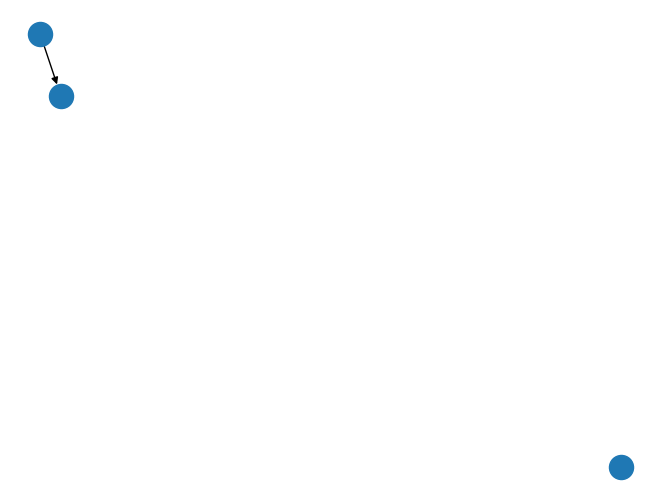

In [27]:
# Visualization
import matplotlib.pyplot as plt
from rustworkx.visualization import mpl_draw

mpl_draw(digraph)